### Exploratory Data Analysis

Before we apply clustering and supervised learning techniques, let's get some idea of the dataset we're working with. First, we import some basic libraries:

In [2]:
# Basic libraries
import numpy as np
import pandas as pd
# Preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
# Default list of stopwords
count_vector = CountVectorizer(stop_words="english")

In [3]:
# Load datasets
steam_df = pd.read_csv('./steam_games.csv',delimiter=';', low_memory=False)
steam_df.dropna(inplace=True)
steam_df.head()

,App ID,Name,Short Description,Developer,Publisher,Genre,Tags,Type,Categories,Owners,...,Price,Initial Price,Discount,CCU,Languages,Platforms,Release Date,Required Age,Website,Header Image
3,1000030,"Cook, Serve, Delicious! 3?!","Cook, serve and manage your food truck as you ...",Vertigo Gaming Inc.,Vertigo Gaming Inc.,"Action, Indie, Simulation, Strategy","Typing: 221, Management: 213, Casual: 209, Dif...",game,"Multi-player, Single-player, Co-op, Steam Achi...","100,000 .. 200,000",...,1999,1999,0,76,English,"windows, mac",2020/10/14,0,http://www.cookservedelicious.com,https://cdn.akamai.steamstatic.com/steam/apps/...
6,1000100,干支セトラ 陽ノ卷｜干支etc. 陽之卷,耐用年数を超えて綻びゆく都市風水を修復するため、次代の風水師候補に選ばれた主人公。 綻びから...,七月九日,Starship Studio,"Adventure, Indie, RPG, Strategy","Adventure: 20, Indie: 20, RPG: 20, Strategy: 2...",game,"Single-player, Steam Achievements, Steam Cloud","0 .. 20,000",...,1299,1299,0,0,"Japanese, Simplified Chinese, Traditional Chinese",windows,2019/01/24,0,http://0709.noor.jp/etc,https://cdn.akamai.steamstatic.com/steam/apps/...
7,1000110,Jumping Master(跳跳大咖),Jumping Master is a innovative casual competit...,重庆环游者网络科技,重庆环游者网络科技,"Action, Adventure, Casual, Free to Play, Massi...","Free to Play: 26, Massively Multiplayer: 25, A...",game,"Multi-player, Single-player, Co-op, Online PvP...","20,000 .. 50,000",...,0,0,0,0,"English, Simplified Chinese, Traditional Chinese",windows,2019/04/8,0,http://www.huanyz.com/bzjj/,https://cdn.akamai.steamstatic.com/steam/apps/...
9,1000280,Tower of Origin2-Worm's Nest,As the protagonist，the Balrog Princess— HongYe...,Villain Role,Villain Role,"Indie, RPG","Sexual Content: 155, Mature: 150, Female Prota...",game,Single-player,"0 .. 20,000",...,1399,1399,0,0,"English, Simplified Chinese, Traditional Chinese",windows,2021/09/9,0,https://weibo.com/u/7623414897,https://cdn.akamai.steamstatic.com/steam/apps/...
11,1000360,Hellish Quart,"A physics-based, realistic, 3D sword dueling g...",Kubold,Kubold,"Action, Early Access","Early Access: 222, 3D Fighter: 201, Swordplay:...",game,"Multi-player, Single-player, Shared/Split Scre...","200,000 .. 500,000",...,1699,1699,0,59,"English, Simplified Chinese",windows,2021/02/16,0,https://www.hellishquart.com,https://cdn.akamai.steamstatic.com/steam/apps/...


In [4]:
steam_df['Owners'].value_counts()

Owners
0 .. 20,000                   18000
20,000 .. 50,000               4194
50,000 .. 100,000              2366
100,000 .. 200,000             1729
200,000 .. 500,000             1627
500,000 .. 1,000,000            752
1,000,000 .. 2,000,000          449
2,000,000 .. 5,000,000          289
5,000,000 .. 10,000,000          82
10,000,000 .. 20,000,000         35
20,000,000 .. 50,000,000         20
50,000,000 .. 100,000,000         4
200,000,000 .. 500,000,000        1
Name: count, dtype: int64

We first notice that the "owners" attribute does not track the exact number of owners. Instead, it has three discrete bins per order of magnitude. Most games are in the least popular category: less than 20,000 owners. This rules out one idea for pre-processing, which is to eliminate the least popular games in order to clean bad entries; doing so would eliminate most games in the entire dataset.

In [5]:
steam_df['Type'].value_counts()

Type
game    29548
Name: count, dtype: int64

The "type" attribute will not be of use here.

<Axes: xlabel='# words in short description', ylabel='# games'>

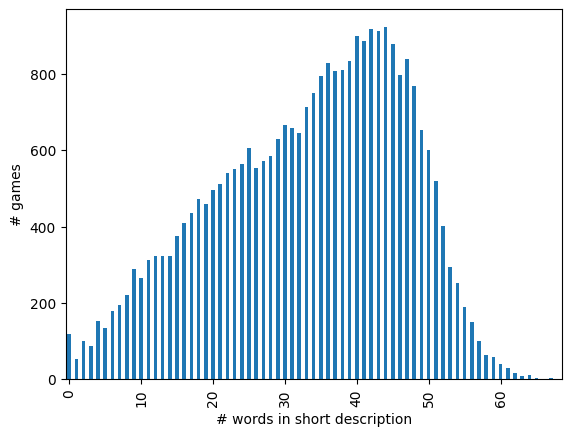

In [6]:
lengths = steam_df['Short Description'].apply(lambda x: len(x.split())).sort_values()
lengths.value_counts(sort=False).plot.bar(xticks=range(0,max(lengths),10),xlabel="# words in short description",ylabel="# games")

Descriptions are, thankfully, of a reasonable length. If they were too long, we would need to preprocess them to limit their length. If most of them were too short, they might not contain enough useful information. Many of the shorter descriptions are likely outliers (i.e. in languages where ordinary spaces are not used to separate words and/or using a "word count" doesn't make sense).

In [7]:
steam_df.loc[16428]

App ID                                                         1524160
Name                                                         孙美琪疑案 第四季
Short Description      《孙美琪疑案》系列第四季，共包含6个DLC，分别是：王勇、兰芝、陈庭君、哈朵、阿加塔、冯跃进。
Developer                                                   QZQ Studio
Publisher                                                  H.P.Y.S,LLC
Genre                                            Adventure, Indie, RPG
Tags                 Adventure: 215, RPG: 207, Puzzle: 184, Interac...
Type                                                              game
Categories                                               Single-player
Owners                                               50,000 .. 100,000
Positive Reviews                                                     3
Negative Reviews                                                     1
Price                                                                0
Initial Price                                                        0
Discou

Some of these columns contain lists of features such as tags or genres, but we can fairly easily extract the individual items to analyze them.

In [8]:
import re
tag_counts = steam_df['Tags'].apply(lambda x: re.sub(": [0-9]+","",x).split(", ")).explode().value_counts()
# Most popular tags
print("# of tags:", tag_counts.size)
tag_counts[:10]

# of tags: 441


Tags
Indie           19333
Action          14013
Singleplayer    13993
Adventure       13044
Casual          11631
2D               7114
Strategy         6829
Simulation       6303
RPG              5760
Atmospheric      5064
Name: count, dtype: int64

In [9]:
# "Average" tags
tag_counts[200:210]

Tags
World War II           339
Parkour                334
Soundtrack             331
Alternate History      328
Supernatural           322
Grand Strategy         322
Grid-Based Movement    315
Split Screen           315
MMORPG                 310
Match 3                309
Name: count, dtype: int64

In [10]:
# Least popular tags
tag_counts[-10:]

Tags
Hardware         8
Snooker          8
Feature Film     8
ATV              6
Volleyball       5
Job Simulator    5
Tile-Matching    3
Coding           3
Shop Keeper      3
Masterpiece      1
Name: count, dtype: int64

In [ ]:
tag_counts.plot.bar(xticks=range(0, 441, 20), xlabel="Tag #", width=1.0, title="Barplot of tag frequency")

In [ ]:
tag_counts.hist(bins=193)

There are over 400 tags, and most of them apply to very few games. About half of all tags apply to 2% of games, while only a few dozen tags apply to more than 5-10% of games. It's likely that tagging isn't very closely regulated; apparently, there are 8 "games" tagged with "Feature Film".

Tags are a promising way to compare user interests. Looking at the middle of the list in terms of frequency, there are tags like "World War 2" and "Alternate History" that correspond to specific user interests (i.e. a user who likes one alternate history game is likely to enjoy another).

Let's see how many tags an individual game tends to have:

<Axes: >

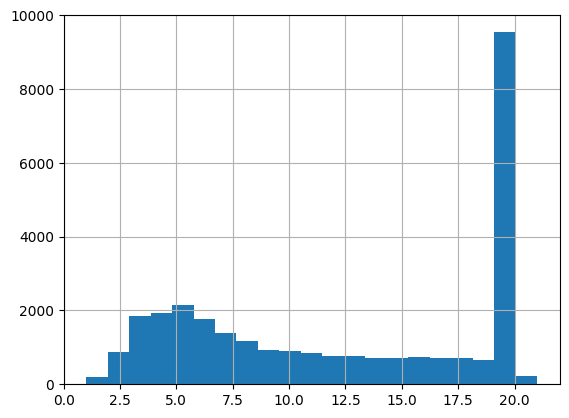

In [15]:
num_tags = steam_df['Tags'].apply(lambda x: len(re.sub(": [0-9]+","",x).split(", ")))
num_tags.hist(bins=21)

This is interesting; there seems to be a maximum of 20 tags for a given game. However, there are some outliers that seem to have 21 tags. What's up with that? Let's see if it's something obvious.

In [31]:
print(steam_df[num_tags==21].iloc[0]['Name'])
print(steam_df[num_tags==21].iloc[0]['Tags'])

Angry Birds VR: Isle of Pigs
Family Friendly: 291, Casual: 288, VR: 287, Puzzle: 280, Physics: 272, Level Editor: 265, Cult Classic: 259, Singleplayer: 256, Great Soundtrack: 251, Tactical: 248, Sandbox: 244, 6DOF: 239, Cute: 236, Relaxing: 227, Beautiful: 225, Cartoon: 223, Immersive: 220, Difficult: 216, Cartoony: 210, Memes: 196, VR Only: 1


We can see the clear outlier: VR Only is tagged only once. Indeed, looking at the entry for this game on Steam, the "VR Only" tag is nowhere to be found. So this is the 21st tag.

Now, let's see if the "genre" column is as useful.

In [72]:
genre_counts = steam_df['Genre'].apply(lambda x: x.split(", ")).explode().value_counts()
# Most popular genres
print("# of genres:", genre_counts.size)
genre_counts

# of genres: 27


Genre
Indie                    21009
Action                   13294
Adventure                11934
Casual                   10528
Strategy                  6286
Simulation                5871
RPG                       5375
Early Access              3346
Free to Play              2154
Sports                    1583
Racing                    1145
Massively Multiplayer      963
Utilities                  156
Design & Illustration      100
Violent                     87
Animation & Modeling        86
Education                   73
Gore                        51
Video Production            43
Game Development            40
Software Training           40
Audio Production            38
Sexual Content              26
Web Publishing              25
Nudity                      23
Photo Editing               15
Accounting                   5
Name: count, dtype: int64

<Axes: xlabel='Genre'>

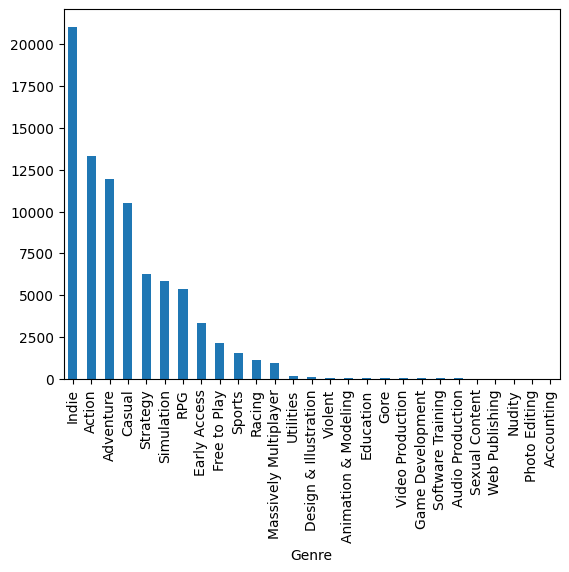

In [60]:
genre_counts.plot.bar()

There are only 27 genres, so we can list all of them. It seems that about half of them are reasonably common, while about half are extremely niche. Just to check, let's look at the 5 games tagged "Accounting":

In [75]:
steam_df[steam_df['Genre'].str.contains("Accounting")]

,App ID,Name,Short Description,Developer,Publisher,Genre,Tags,Type,Categories,Owners,...,Price,Initial Price,Discount,CCU,Languages,Platforms,Release Date,Required Age,Website,Header Image
38208,520210,DreamDesk VR,VR Desktop Environment Access all your softwar...,We AR VR,We AR VR,"Accounting, Animation & Modeling, Audio Produc...","Utilities: 26, Animation & Modeling: 21, Audio...",game,Full controller support,"0 .. 20,000",...,1499,1499,0,0,"English, French, Italian, German, Spanish - Sp...",windows,2016/11/30,0,http://dreamdesk.io,https://cdn.akamai.steamstatic.com/steam/apps/...
39326,551960,DatavizVR Demo,Who says data visualization has to be boring? ...,DatavizVR Inc.,DatavizVR Inc.,"Accounting, Education, Software Training, Util...","Software Training: 31, Utilities: 24, Early Ac...",game,Stats,"0 .. 20,000",...,0,0,0,0,English,windows,2016/12/5,0,http://www.DatavizVR.com,https://cdn.akamai.steamstatic.com/steam/apps/...
48682,803010,Supermedium - Virtual Reality Browser,Supermedium is the virtual reality browser. Na...,Supermedium,Supermedium,"Casual, Free to Play, Indie, Accounting, Anima...","Free to Play: 23, Utilities: 23, Casual: 22, E...",game,Single-player,"50,000 .. 100,000",...,0,0,0,0,English,windows,2018/03/6,0,https://supermedium.com,https://cdn.akamai.steamstatic.com/steam/apps/...
50399,849690,Ghost Mountain Roller Coaster,Ghost Mountain is an epic 12 minutes long virt...,Raw Lion Workshop,Raw Lion Workshop,"Adventure, Casual, Indie, Simulation, Accounting","Adventure: 21, Casual: 21, Indie: 21, Simulati...",game,"Single-player, Full controller support","0 .. 20,000",...,299,299,0,0,English,windows,2018/05/9,0,https://rawlionworkshop.wordpress.com/ghost-mo...,https://cdn.akamai.steamstatic.com/steam/apps/...
53459,934710,英语杀,英语杀是一款网络在线卡牌对战游戏，融入了背单词的创新功能，帮助学生通过游戏来强化英语学习。通...,边玩边学网络科技有限公司,边玩边学网络科技有限公司,"Casual, Free to Play, Indie, RPG, Strategy, Ac...","Free to Play: 84, Indie: 82, Casual: 81, Strat...",game,Single-player,"0 .. 20,000",...,0,0,0,0,"English, Not supported, Simplified Chinese",windows,2018/11/4,0,https://www.yingyusha.com/,https://cdn.akamai.steamstatic.com/steam/apps/...


Apparently, "accounting" is a subset of VR games. At any rate, most of the popular "genres" are either redundant with existing tags. The others are either extremely niche or content warnings (Sexual Content, Nudity, Gore). Therefore, this is probably a less useful column, although the fact that content warnings are included gives it some utility for filtering results.

Finally, let's see what information the "categories" column holds:

In [76]:
category_counts = steam_df['Categories'].apply(lambda x: x.split(", ")).explode().value_counts()
# Most popular categories
print("# of categories:", genre_counts.size)
category_counts

# of categories: 27


Categories
Single-player                 27780
Steam Achievements            16243
Steam Cloud                    9510
Full controller support        8139
Multi-player                   7809
Steam Trading Cards            6941
Partial Controller Support     4754
PvP                            4693
Co-op                          3877
Steam Leaderboards             3584
Online PvP                     3445
Remote Play Together           3339
Shared/Split Screen            2950
Shared/Split Screen PvP        2063
Stats                          2033
Online Co-op                   2028
Shared/Split Screen Co-op      1708
Remote Play on TV              1618
Cross-Platform Multiplayer     1416
Includes level editor          1201
Steam Workshop                 1168
In-App Purchases               1020
Captions available              820
Remote Play on Tablet           677
MMO                             616
Remote Play on Phone            546
LAN PvP                         299
LAN Co-op        

These categories mostly consist of technical features, which are useful to know but probably not quite as useful to statistically analyze.

### Cosine Similarity

We will now use cosine similarity to find the closest games to a given game.

In [40]:
steam_df.dropna(inplace=True)
count_vector.fit(steam_df['Tags'])
# These dataframes take up a lot of memory
doc_array = count_vector.transform(steam_df['Tags']).toarray()
frequency_df = pd.DataFrame(doc_array, columns = count_vector.get_feature_names_out())
similarity_df = pd.DataFrame(cosine_similarity(frequency_df))

MemoryError: Unable to allocate 6.50 GiB for an array with shape (29548, 29548) and data type float64

In [ ]:
steam_df.shape

In [ ]:
frequency_df.shape

In [ ]:
similarity_df.shape

In [ ]:
similarity_df.tail(1)

In [35]:
def get_similar_games(df, game_name, sim_df, thresh):
    game_info = sim_df.loc[df['Name'] == game_name, :]
    inds = game_info.loc[:,((game_info > thresh)).all()]
    t = df.iloc[inds.columns, :].where(df['Name'] != game_name)
    i = inds.melt().set_index('variable')
    t['cosine_sim'] = i
    return t.dropna()

In [ ]:
steam_df.reset_index(inplace=True)

In [ ]:
get_similar_games(steam_df, 'Becalm', similarity_df, 0.5).sort_values('cosine_sim', ascending=False).head()

In [ ]:
get_similar_games(steam_df, 'Counter-Strike: Global Offensive', similarity_df, 0.3).sort_values('cosine_sim', ascending=False).head()

In [ ]:
get_similar_games(steam_df, 'RimWorld', similarity_df, 0.3).sort_values('cosine_sim', ascending=False).head()

In [ ]:
#Tool to find games if don't know exact name.
steam_df[steam_df['Name'].str.contains('Rim')]

### Bonus: Itch.io Dataset

Initially, we had plans for both a dataset from Steam and a dataset from Itch.io. We later chose to abandon the latter dataset to focus on Steam games, due to some differences between the datasets. For the sake of documentation, however, we are including our initial work on the Itch.io dataset here. First, we read in the dataset to get a sense of what we're working with:

In [9]:
kaggle_df = pd.read_csv('./itch.csv',delimiter=';',encoding = "ISO-8859-1")
kaggle_df.head()

,Name,Description,Price,Author,Rated,RatingNumber,Genre,Link,Platforms,Languages,Tool,Tags
0,Friday Night Funkin',The coolest rhythm game,$0,ninjamuffin99,"94,35021",10011,Rhythm,https://ninja-muffin24.itch.io/funkin,"Windows, macOS, Linux, HTML5",Unknown,"OpenFL, IndieCade, Haxe",2D
1,Sort the Court!,"Give your decree in simple yes or no answers, ...",$0,Graeme Borland,"94,08258",6709,Simulation,https://graebor.itch.io/sort-the-court,"Windows, macOS, Linux, HTML5",English,Unity,"Cute, Ludum Dare 34"
2,We Become What We Behold,"a game about news cycles, vicious cycles, infi...",$0,Nicky Case!,"95,42467",4839,Unknown,https://ncase.itch.io/wbwwb,HTML5,English,PixiJS,"Comedy, Dark Humor, Experimental"
3,HoloCure,"A 'survivors' like, free unofficial Hololive f...",$0,Kay Yu,"98,84398",4775,Action,https://kay-yu.itch.io/holocure,Windows,"English, Japanese",GameMaker: Studio,"Fangame, hololive, Pixel Art, Roguelite, Singl..."
4,?Our Life: Beginnings & Always,Grow from childhood to adulthood with the lone...,$0,GBPatch,"98,92411",4480,Visual Novel,https://gbpatch.itch.io/our-life,"Windows, macOS, Linux, Android",Unknown,Unknown,"amare, Comedy, Dating Sim, Gay, LGBT, Meaningf..."


There are a number of attributes we could work with, but those relevant to the genre or style of a game are mostly discrete. Therefore, we'll start by using the descriptions of each game in a bag-of-words representation, using the default list of stopwords for convenience.

In [13]:
# Using base list of stop words
count_vector = CountVectorizer(stop_words="english")

In [14]:
# Preprocessing of kaggle dataset
count_vector.fit(kaggle_df['Description'])
doc_array = count_vector.transform(kaggle_df['Description']).toarray()
frequency_matrix = pd.DataFrame(doc_array, columns = count_vector.get_feature_names_out())
d = {}
d['bag_of_words_descripton'] = frequency_matrix
d['info'] = kaggle_df
d['similarity'] = pd.DataFrame(cosine_similarity(frequency_matrix))
kaggle_df = pd.concat(d, axis=1)
kaggle_df.head()

bag_of_words_descripton                                       ...  \
                       00 000 00s 012 04 087 0h 0space 0x72 10  ...   
0                       0   0   0   0  0   0  0      0    0  0  ...   
1                       0   0   0   0  0   0  0      0    0  0  ...   
2                       0   0   0   0  0   0  0      0    0  0  ...   
3                       0   0   0   0  0   0  0      0    0  0  ...   
4                       0   0   0   0  0   0  0      0    0  0  ...   

  similarity                                                              
        9116 9117 9118 9119      9120 9121 9122      9123      9124 9125  
0        0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.000000  0.288675  0.0  
1        0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.169031  0.000000  0.0  
2        0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.000000  0.138675  0.0  
3        0.0  0.0  0.0  0.0  0.209657  0.0  0.0  0.000000  0.188982  0.0  
4        0.0  0.0  0.0  0.0  0.000000  0.0  0.0  0.000000  0.000000  0.0  

[5 rows x 18874 columns]

Now that we've preprocessed the data, we can use a basic cosine similarity metric to find the closest descriptions to any given game.

In [15]:
# Takes in a dataframe, an input game, and dictionary keys for
def get_similar_games(df, game_name, info_col, sim_col, thresh):
    temp = df[df[info_col]['Name'] == game_name][sim_col]
    inds = temp.loc[:,((temp > thresh) & (temp < 1.0)).all()]
    t = df.iloc[inds.columns]['info']
    i = inds.melt().set_index('variable')
    t['cosine_sim'] = i
    return t

In [26]:
get_similar_games(kaggle_df, 'Friday Night Funkin\'', 'info', 'similarity', 0.66).sort_values('cosine_sim', ascending=False).head()

,Name,Description,Price,Author,Rated,RatingNumber,Genre,Link,Platforms,Languages,Tool,Tags,cosine_sim
264,Friday Night Funkin' (Ludum Dare Prototype),Probably the coolest rhythm game,$0,ninjamuffin99,"89,44099",483,Rhythm,https://ninja-muffin24.itch.io/friday-night-fu...,"Windows, macOS, HTML5",Unknown,"Haxe, OpenFL","2D, Cute, Ludum Dare, Ludum Dare 47, Music",0.866025
4148,Friday Night Funkin' VR,The coolest rhythm game in first person,$0,Ben Kurtin,"96,42857",28,Rhythm,https://thisisbennyk.itch.io/funkin-vr,Android,English,Godot,"3D, Fangame, Funny, Virtual Reality (VR)",0.866025
6937,Dancing Angel,Rhythm game,$0,snowinrain,"87,27273",11,Rhythm,https://snowinrain.itch.io/dancing-angels,Windows,English,Unity,"3D, Anime, Cute, dancing, Fantasy, Music, musi...",0.816497
3187,ONE PUNCH BEAT (GDKO Round 6),the one button rhythm game!,$0,Federico Calchera,"92,85714",42,Rhythm,https://federico-calchera.itch.io/one-punch-beat,HTML5,Unknown,Construct,"2D, Anime, Arcade, Cyberpunk, Fast-Paced, Musi...",0.666667
4908,BOOBSTAR,JJBA Rhythm Game,$0,Nancy10069,"96,19048",21,Rhythm,https://nancy10069.itch.io/boobstar,HTML5,Unknown,Unity,"2D, Fangame, jjba, jojos-bizarre-adventure",0.666667


In [27]:
get_similar_games(kaggle_df, 'Sort the Court!', 'info', 'similarity', 0.25).sort_values('cosine_sim', ascending=False).head()

,Name,Description,Price,Author,Rated,RatingNumber,Genre,Link,Platforms,Languages,Tool,Tags,cosine_sim
1,Sort the Court!,"Give your decree in simple yes or no answers, ...",$0,Graeme Borland,"94,08258",6709,Simulation,https://graebor.itch.io/sort-the-court,"Windows, macOS, Linux, HTML5",English,Unity,"Cute, Ludum Dare 34",1.000000
4278,soon,simple things become routine and grow from there.,$0,Stuffed Wombat,"96,15385",26,Unknown,https://stuffedwombat.itch.io/soon,HTML5,Unknown,Construct,"3D, First-Person, gameaweek2022, Horror, ritua...",0.377964
575,The Invader,You find yourself in a kingdom do what ever yo...,$0,FadingCometStudios,"96,30769",260,Adventure,https://fadingcometstudios.itch.io/the-invader,"Windows, macOS, Linux",Unknown,Unknown,"3D, Low-poly, Point & Click, Singleplayer, Top...",0.267261
1072,Quit the game to win,It's not as simple as it sounds.,$0,Andrea Pignataro,"81,84211",152,Puzzle,https://approductions.itch.io/quit-the-game-to...,Windows,English,Unknown,"2D, Casual, Comedy, Difficult, Horror, mind-be...",0.267261
4296,Start Powerless,"You can only move at first, but powerups will ...",$0,rob1221,"93,07692",26,Platformer,https://rob1221.itch.io/start-powerless,HTML5,English,"ChipTone, OpenFL, Stencyl, Inkscape","2D, Ludum Dare, Ludum Dare 45, Puzzle-Platform...",0.267261


We can see that results are mixed. For some games, the description contains genre keywords like "rhythm", which allow other games with the same keyword to be easily found by cosine similarity (in this case, it helps that the game is so popular that it has multiple spinoffs). For others, however, the description is not so helpful, as it describes how the game works in simple language with no particular genre-defining keywords.